In [1]:
%pylab inline
from inspect import getsource
import scipy.signal as signal
from IPython.display import Audio, display
from IPython.display import Image, SVG

Populating the interactive namespace from numpy and matplotlib


In [2]:
from gps_helper.smoothing import RecursiveAverage, MovingAverageFilter, LowPassFilter

In [3]:
pylab.rcParams['savefig.dpi'] = 100 # default 72
%config InlineBackend.figure_formats=['svg'] # SVG inline viewing

# Signal Filtering

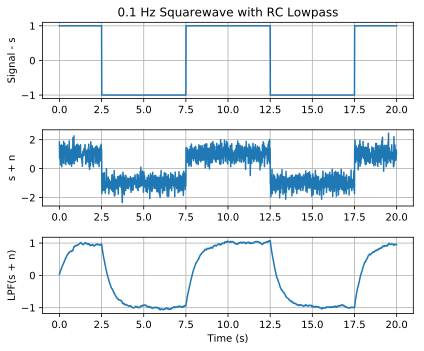

In [4]:
figure(figsize=(6,5))
f0 =0.1
fs = 100
t = arange(0,20,1/fs)
s = sign(cos(2*pi*.1*t))
subplot(311)
title(r'0.1 Hz Squarewave with RC Lowpass')
ylabel(r'Signal - s')
plot(t,s)
grid()
subplot(312)
std_n = 0.4
r = s + std_n*randn(len(s))
plot(t,r)
ylabel(r's + n')
grid()
subplot(313)
f3 = 3*f0
a = exp(-2*pi*f3/fs)
rf = signal.lfilter([1-a],[1,-a],r)
plot(t,rf)
xlabel(r'Time (s)')
ylabel(r'LPF(s + n)')
grid()
tight_layout()

# Measurement Filtering

In [5]:
print(getsource(RecursiveAverage))

class RecursiveAverage:
    """
    Recursive average filter implementation.
    """

    def __init__(self):
        self.k = 0.0
        self.x_k = 0

    def next_sample(self, x):
        """
        Process the next data sample.

        :param x: Next data sample to compute average
        :return: float
        """
        self.k += 1.0
        self.x_k = ((self.k - 1.) / self.k) * self.x_k + x / self.k
        return self.x_k



In [6]:
print(getsource(MovingAverageFilter))

class MovingAverageFilter:
    """
    Moving average filter implementation.
    """

    def __init__(self, n):
        """
        :param n: Number of samples to move the average over
        """
        self.n = float(n)
        self.x_k = [0.0 for ii in range(0, int(self.n))]

    def next_sample(self, x):
        """
        Process the next sample.

        :param x: Next data sample to compute average
        :return: float
        """
        self.x_k[1:] = self.x_k[:-1]
        self.x_k[0] = x
        return sum(self.x_k) / self.n



In [7]:
print(getsource(LowPassFilter))

class LowPassFilter:
    """
    Low pass filter implementation.
    """

    def __init__(self, alpha):
        """
        Provide the alpha weighting value to initialize.
        :param alpha: Weighting value
        """
        self.alpha = alpha
        self.prev = 0

    def next_sample(self, x):
        """
        Process the next sample.

        :param x: Next sample value.
        :return: float
        """
        xlpf = self.alpha * self.prev + (1 - self.alpha) * x
        self.prev = xlpf
        return xlpf



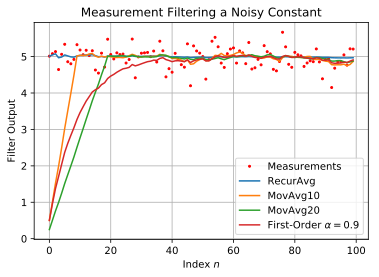

In [8]:
Npts = 100
x = 5
v = 0.3*randn(Npts)
z = x + v
yravg = zeros_like(z)
ravg = RecursiveAverage()
y10 = zeros_like(z)
movavg10 = MovingAverageFilter(10)
y20 = zeros_like(z)
movavg20 = MovingAverageFilter(20)
lpf09 = LowPassFilter(0.9)
yfof09 = zeros_like(z)
for k, z_k in enumerate(z):
    yravg[k] = ravg.next_sample(z_k)
    y10[k] = movavg10.next_sample(z_k)
    y20[k] = movavg20.next_sample(z_k)
    yfof09[k] = lpf09.next_sample(z_k)
plot(arange(Npts),z,'r.',markersize=4)
plot(arange(Npts),yravg)
plot(arange(Npts),y10)
plot(arange(Npts),y20)
plot(arange(Npts),yfof09)
legend((r'Measurements',r'RecurAvg',r'MovAvg10',
        r'MovAvg20',r'First-Order $\alpha=0.9$'))
ylabel(r'Filter Output')
xlabel(r'Index $n$')
title(r'Measurement Filtering a Noisy Constant')
grid();

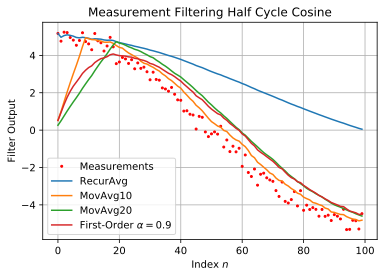

In [9]:
Npts = 100
n = arange(0,100)
x = 5*cos(2*pi*n/200)
v = 0.3*randn(Npts)
z = x + v
yravg = zeros_like(z)
ravg = RecursiveAverage()
y10 = zeros_like(z)
movavg10 = MovingAverageFilter(10)
y20 = zeros_like(z)
movavg20 = MovingAverageFilter(20)
lpf09 = LowPassFilter(0.9)
yfof09 = zeros_like(z)
for k, z_k in enumerate(z):
    yravg[k] = ravg.next_sample(z_k)
    y10[k] = movavg10.next_sample(z_k)
    y20[k] = movavg20.next_sample(z_k)
    yfof09[k] = lpf09.next_sample(z_k)
plot(arange(Npts),z,'r.',markersize=4)
plot(arange(Npts),yravg)
plot(arange(Npts),y10)
plot(arange(Npts),y20)
plot(arange(Npts),yfof09)
legend((r'Measurements',r'RecurAvg',r'MovAvg10',
        r'MovAvg20',r'First-Order $\alpha=0.9$'))
ylabel(r'Filter Output')
xlabel(r'Index $n$')
title(r'Measurement Filtering Half Cycle Cosine')
grid();

# Kalman Filtering Background
It was in 1960 that the Kalman filter was born. Today we are many many innovations beyond its humble beginnings.

<img src="figs/Kalman_variables.png" width="50%">

In [10]:
# Image('figs/Kalman_variables.png',width='60%')

<img src="figs/Kalman_Filter.png" width="60%">

In [11]:
# Image('figs/Kalman_Filter.png',width='70%')

# Basic Examples from Kim

## Chapter 10.2: Estimating a Constant Voltage

In [12]:
class GetVoltage(object):
    """
    A class for generating the battery voltage measurements
    
    Mark Wickert February 2018
    """
    
    def __init__ (self, batt_voltage = 14.4, dt = 0.2, sigma_w = 2):
        """
        Initialize the object
        """
        self.sigma_w = sigma_w
        self.Voltage_set = batt_voltage
        
        self.dt = dt
        
        
    def measurement(self):
        """
        Take a measurement
        """
        w = 0 + self.sigma_w*random.randn(1)[0]
        z = self.Voltage_set + w
        return z

In [13]:
class SimpleKalman(object):
    """
    Kim Chapter 10.2 Battery voltage estimation with measurement noise
    
    Python 3.x is assumed so the operator @ can be used for matrix multiply
    
    Mark Wickert February 2018
    """
    
    
    def __init__ (self, dt = 0.2, initial_state = 14, P = 6):
        """
        Initialize the object
        """
        self.dt = dt
        self.A = array([[1]])
        self.H = array([[1]])
        # Process model covariance
        self.Q = array([[0]])
        # Measurement model covariance 
        self.R = 4
        self.x = array([[initial_state]])
        # Error covariance initialize 
        self.P = P*eye(1)

        
    def next_sample(self,z):
        """
        Update the Kalman filter state by inputting a new 
        scalar measurement. Return the state array as a tuple
        Update all other Kalman filter quantities
        """
        xp = self.A @ self.x
        Pp = self.A @ self.P @ self.A.T + self.Q
        
        self.K = Pp @ self.H.T * inv(self.H @ Pp @ self.H.T + self.R)
        
        self.x = xp + self.K @ (array([[z]] - self.H @ xp))
        self.P = Pp - self.K @ self.H @ Pp
        
        self.volt = self.x[0]
        return self.volt

In [14]:
dt = 0.1
t = arange(0,10+dt,dt)
Xsaved = zeros((len(t),2))
Zsaved = zeros(len(t))
Ksaved = zeros(len(t))
Psaved = zeros(len(t))

# Create objects for the simulation
GetVoltage1 = GetVoltage(14.0,dt,sigma_w = 2)
SimpleKalman1 = SimpleKalman(initial_state=14)

for k in range(len(t)):
    z = GetVoltage1.measurement()
    Xsaved[k,:] = SimpleKalman1.next_sample(z)
    Zsaved[k] = z
    Ksaved[k] = SimpleKalman1.K
    Psaved[k] = SimpleKalman1.P

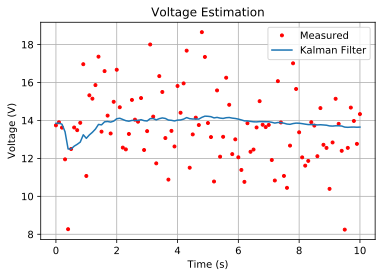

In [15]:
plot(t,Zsaved,'r.')
plot(t,Xsaved[:,0])
ylabel(r'Voltage (V)')
xlabel(r'Time (s)')
legend((r'Measured',r'Kalman Filter'),loc='best')
title(r'Voltage Estimation')
grid();

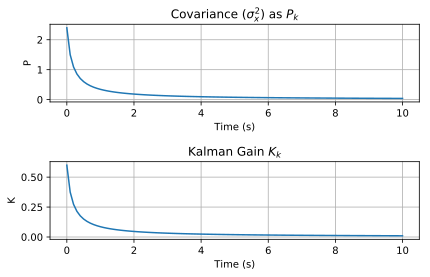

In [16]:
subplot(211)
plot(t,Psaved)
ylabel(r'P')
xlabel(r'Time (s)')
title(r'Covariance ($\sigma_x^2$) as $P_k$')
grid();
subplot(212)
plot(t,Ksaved)
ylabel(r'K')
xlabel(r'Time (s)')
title(r'Kalman Gain $K_k$')
grid();
tight_layout()

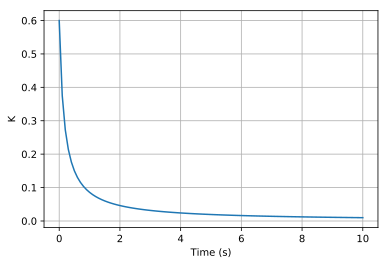

In [17]:
plot(t,Ksaved)
ylabel(r'K')
xlabel(r'Time (s)')
grid();

## Notes Radial Position Example

In [18]:
class GetPosVel(object):
    """
    A class for generating position and velocity 
    measurements and truth values 
    of the state vector.
    
    Mark Wickert May 2018
    """
    
    
    def __init__ (self,pos_set = 0, vel_set = 80.0, dt = 0.1, 
                  Q = [[1,0],[0,3]], R = [[10,0],[0,2]]):
        """
        Initialize the object
        """
        self.actual_pos = pos_set
        self.actual_vel = vel_set
        
        self.Q = array(Q)
        self.R = array(R)
        self.dt = dt
        
        
    def measurement(self):
        """
        Take a measurement
        """
        # Truth position and velocity
        self.actual_vel = self.actual_vel
        self.actual_pos = self.actual_pos \
        + self.actual_vel*self.dt
            
        # Measured value is truth plus measurement error
        z1 = self.actual_pos + sqrt(self.R[0,0])*random.randn()
        z2 = self.actual_vel + sqrt(self.R[1,1])*random.randn()
        return array([[z1],[z2]])

In [19]:
class PosKalman(object):
    """
    Position Estimation from Position and Velocity Measurements
    
    Python 3.x is assumed so the operator @ can be used for matrix multiply
    
    Mark Wickert May 2018
    """

    
    def __init__ (self, Q, R, initial_state = [0, 20], dt = 0.1):
        """
        Initialize the object
        """
        self.dt = dt
        self.A = array([[1, dt],[0,1]])
        self.H = array([[1,0],[0,1]])
        # Process model covariance
        self.Q = Q
        # Measurement model covariance 
        self.R = R
        self.x = array([[initial_state[0]],[initial_state[1]]])
        # Error covariance initialize 
        self.P = 5*eye(2)
        # Initialize state
        self.x = array([[0.0],[0.0]])

        
    def next_sample(self,z):
        """
        Update the Kalman filter state by inputting a new 
        scalar measurement. Return the state array as a tuple
        Update all other Kalman filter quantities
        """
        xp = self.A @ self.x
        Pp = self.A @ self.P @ self.A.T + self.Q
        
        self.K = Pp @ self.H.T * inv(self.H @ Pp @ self.H.T + self.R)
        
        self.x = xp + self.K @ (z - self.H @ xp)
        self.P = Pp - self.K @ self.H @ Pp
        return self.x

### Run a Simulation

In [20]:
dt = 0.1
t = arange(0,10+dt,dt)
Xsaved = zeros((2,len(t)))
Zsaved = zeros((2,len(t)))
Psaved = zeros(len(t))
Vsaved = zeros(len(t))
# Save history of error covariance matrix diagonal 
P_diag = zeros((len(t),2))

# Create objects for the simulation
Q = array([[1,0],[0,3]])
R = array([[10,0],[0,2]])
GetPos1 = GetPosVel(Q=Q,R=R,dt=dt)
PosKalman1 = PosKalman(Q,R, initial_state=[0,80])

for k in range(len(t)):
    # take a measurement
    z = GetPos1.measurement()
    # Update the Kalman filter
    Xsaved[:,k,None] = PosKalman1.next_sample(z)
    Zsaved[:,k,None] = z
    Psaved[k] = GetPos1.actual_pos
    Vsaved[k] = GetPos1.actual_vel
    P_diag[k,:] = PosKalman1.P.diagonal()

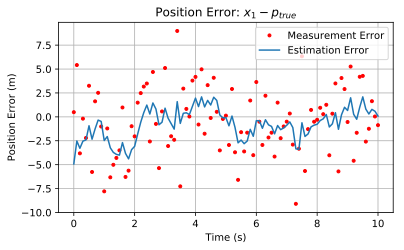

In [21]:
figure(figsize=(6,3.5))
plot(t,Zsaved[0,:]-Psaved,'r.')
plot(t,Xsaved[0,:]-Psaved)
xlabel(r'Time (s)')
ylabel(r'Position Error (m)')
title(r'Position Error: $x_1 - p_{true}$')
legend((r'Measurement Error',r'Estimation Error'))
grid();

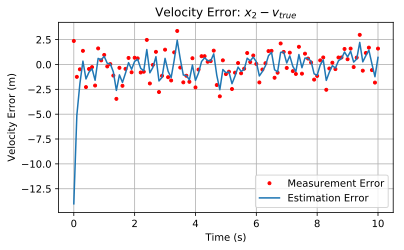

In [22]:
figure(figsize=(6,3.5))
plot(t,Zsaved[1,:]-Vsaved,'r.')
plot(t,Xsaved[1,:]-Vsaved)
xlabel(r'Time (s)')
ylabel(r'Velocity Error (m)')
title(r'Velocity Error: $x_2 - v_{true}$')
legend((r'Measurement Error',r'Estimation Error'))
grid();

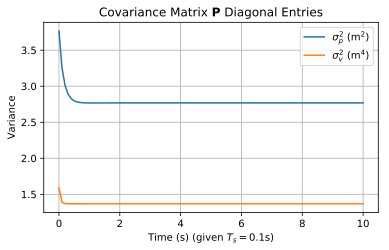

In [23]:
figure(figsize=(6,3.5))
plot(t,P_diag[:,0])
plot(t,P_diag[:,1])
title(r'Covariance Matrix $\mathbf{P}$ Diagonal Entries')
ylabel(r'Variance')
xlabel(r'Time (s) (given $T_s = 0.1$s)')
legend((r'$\sigma_p^2$ (m$^2$)',r'$\sigma_v^2$ (m$^4$)'))
grid();

## Chapter 11.2 & 11.3: Estimating Velocity from Position

In [24]:
class GetPos(object):
    """
    A class for generating position measurements as found in Kim
    
    Mark Wickert December 2017
    """
    
    
    def __init__ (self,Posp = 0, Vel_set = 80.0, dt = 0.1, 
                  var_w = 10.0, var_v = 10.0):
        """
        Initialize the object
        """
        self.Posp = Posp
        self.Vel_set = Vel_set
        self.Velp = Vel_set
        
        self.dt = dt
        
        self.var_w = var_w
        self.var_v = var_v
        
        
    def measurement(self):
        """
        Take a measurement
        """
        # The velocity process noise
        w = 0 + self.var_w*random.randn(1)[0]
        # The position measurement noise
        v = 0 + self.var_v*random.randn(1)[0]
        
        # Update the position measurement
        z = self.Posp + self.Velp*self.dt + v
        # Also update the truth values of position and velocity
        self.Posp = z - v
        self.Velp = self.Vel_set + w
        return z

In [25]:
class DvKalman(object):
    """
    Kim Chapter 11.2 Velocity from Position Estimation
    
    Python 3.x is assumed so the operator @ can be used for matrix multiply
    
    Mark Wickert December 2017
    """

    
    def __init__ (self,initial_state = [0, 20]):
        """
        Initialize the object
        """
        self.dt = 0.1
        self.A = array([[1, self.dt],[0,1]])
        self.H = array([[1,0]])
        # Process model covariance
        self.Q = array([[1,0],[0,3]])
        # Measurement model covariance 
        self.R = 10
        self.x = array([[initial_state[0]],[initial_state[1]]])
        # Error covariance initialize 
        self.P = 5*eye(2)
        # Initialize pos and vel
        self.pos = 0.0
        self.vel = 0.0

        
    def next_sample(self,z):
        """
        Update the Kalman filter state by inputting a new 
        scalar measurement. Return the state array as a tuple
        Update all other Kalman filter quantities
        """
        xp = self.A @ self.x
        Pp = self.A @ self.P @ self.A.T + self.Q
        
        self.K = Pp @ self.H.T * inv(self.H @ Pp @ self.H.T + self.R)
        
        self.x = xp + self.K @ (array([[z]] - self.H @ xp))
        self.P = Pp - self.K @ self.H @ Pp
        
        self.pos = self.x[0]
        self.vel = self.x[1]
        return self.pos, self.vel

### Run a Simulation

In [26]:
dt = 0.1
t = arange(0,10+dt,dt)
Xsaved = zeros((len(t),2))
Zsaved = zeros(len(t))
Vsaved = zeros(len(t))

# Create objects for the simulation
GetPos1 = GetPos()
DvKalman1 = DvKalman()

for k in range(len(t)):
    z = GetPos1.measurement()
    # pos, vel = DvKalman1.update(z)
    
    Xsaved[k,:] = DvKalman1.next_sample(z)
    Zsaved[k] = z
    Vsaved[k] = GetPos1.Velp

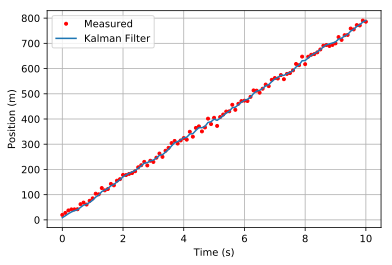

In [27]:
plot(t,Zsaved,'r.')
plot(t,Xsaved[:,0])
ylabel(r'Position (m)')
xlabel(r'Time (s)')
legend((r'Measured',r'Kalman Filter'),loc='best')
grid();

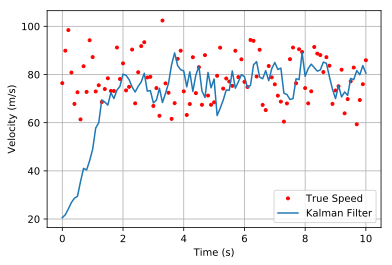

In [28]:
plot(t,Vsaved,'r.')
plot(t,Xsaved[:,1])
ylabel(r'Velocity (m/s)')
xlabel(r'Time (s)')
legend((r'True Speed',r'Kalman Filter'),loc='best')
grid();

## Chapter 11.4: Estimating Position from Velocity

In [29]:
class GetVel(object):
    """
    A class for generating velocity measurements as found in Kim 11.4
    
    Mark Wickert December 2017
    """
    
    
    def __init__ (self,Pos_set = 0, Vel_set = 80.0, dt = 0.1, var_v = 10.0):
        """
        Initialize the object
        """
        self.Posp = Pos_set
        self.Vel_set = Vel_set
        self.Velp = Vel_set
        
        self.dt = dt
        
        self.var_v = var_v
        
        
    def measurement(self):
        """
        Take a measurement
        """
        # The velocity measurement noise
        v = 0 + self.var_v*random.randn(1)[0]
        
        # Also update the truth values of position and velocity
        self.Posp += self.Velp*self.dt
        self.Velp = self.Vel_set + v
        z = self.Velp
        return z

In [30]:
class IntKalman(object):
    """
    Kim Chapter 11.4 Position from Velocity Estimation
    
    Python 3.x is assumed so the operator @ can be used for matrix multiply
    
    Mark Wickert December 2017
    """

    
    def __init__ (self,initial_state = [0, 20]):
        """
        Initialize the object
        """
        self.dt = 0.1
        self.A = array([[1, dt],[0,1]])
        self.H = array([[0,1]])
        # Process model covariance
        self.Q = array([[1,0],[0,3]])
        # Measurement model covariance 
        self.R = 10
        self.x = array([[initial_state[0]],[initial_state[1]]])
        # Error covariance initialize 
        self.P = 5*eye(2)
        # Initialize pos and vel
        self.pos = 0.0
        self.vel = 0.0

        
    def next_sample(self,z):
        """
        Update the Kalman filter state by inputting a new scalar measurement.
        Return the state array as a tuple
        Update all other Kalman filter quantities
        """
        xp = self.A @ self.x
        Pp = self.A @ self.P @ self.A.T + self.Q
        
        self.K = Pp @ self.H.T * inv(self.H @ Pp @ self.H.T + self.R)
        
        self.x = xp + self.K @ (array([[z]] - self.H @ xp))
        self.P = Pp - self.K @ self.H @ Pp
        
        self.pos = self.x[0]
        self.vel = self.x[1]
        return self.pos, self.vel

In [31]:
dt = 0.1
t = arange(0,10+dt,dt)
Xsaved = zeros((len(t),2))
Zsaved = zeros(len(t))
Psaved = zeros(len(t))

# Create objects for the simulation
GetVel1 = GetVel()
IntKalman1 = IntKalman()

for k in range(len(t)):
    z = GetVel1.measurement()
    
    Xsaved[k,:] = IntKalman1.next_sample(z)
    Zsaved[k] = z
    Psaved[k] = GetVel1.Posp

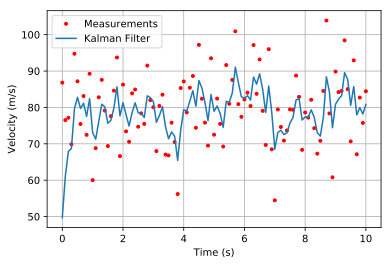

In [32]:
plot(t,Zsaved,'r.')
plot(t,Xsaved[:,1])
ylabel(r'Velocity (m/s)')
xlabel(r'Time (s)')
legend((r'Measurements',r'Kalman Filter'),loc='best')
grid();

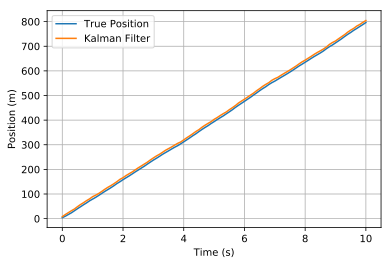

In [33]:
plot(t,Xsaved[:,0])
plot(t,Psaved)
ylabel(r'Position (m)')
xlabel(r'Time (s)')
legend((r'True Position' ,r'Kalman Filter',),loc='best')
grid();

## Chapter 11.5: Measuring Velocity with Sonar

In [34]:
# From scipy.io 
from scipy.io import loadmat

In [35]:
class GetSonar(object):
    """
    A class for playing back sonar altitude measurements as found in Kim 2.4
    and later used in Kim 11.5
    
    Mark Wickert December 2017
    """
    
    
    def __init__ (self,):
        """
        Initialize the object
        """
        sonarD = loadmat('SonarAlt')
        self.h = sonarD['sonarAlt'].flatten()
        self.Max_pts = len(self.h)
        self.k = 0
        
        
    def measurement(self):
        """
        Take a measurement
        """
        
        h = self.h[self.k]
        self.k += 1
        if self.k > self.Max_pts:
            print('Recycling data by starting over')
            self.k = 0
        return h

In [36]:
Nsamples = 500
t = arange(Nsamples)*.02
Xsaved = zeros(Nsamples)
Xmsaved = zeros(Nsamples)
Xksaved = zeros((Nsamples,2))

GetSonar1 = GetSonar()
MovAvgFilter1 = MovingAverageFilter(10)
DvKalman2 = DvKalman()
for k in range(Nsamples):
    xm =GetSonar1.measurement()
    Xmsaved[k] = xm
    Xsaved[k] = MovAvgFilter1.next_sample(xm)
    Xksaved[k,:] = DvKalman2.next_sample(xm)

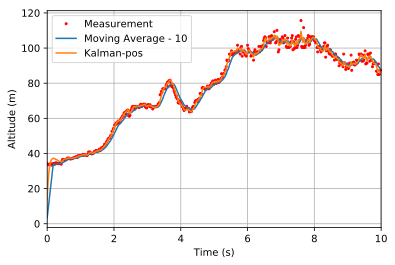

In [37]:
plot(t,Xmsaved,'r.',markersize=4)
plot(t,Xsaved)
plot(t,Xksaved[:,0])
xlim([0,10])
ylabel(r'Altitude (m)')
xlabel(r'Time (s)')
legend((r'Measurement' ,r'Moving Average - 10',r'Kalman-pos'),loc='best')
grid();

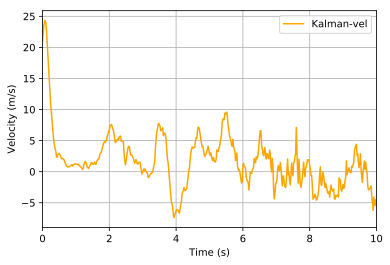

In [38]:
plot(t,Xksaved[:,1],'orange')
xlim([0,10])
ylabel(r'Velocity (m/s)')
xlabel(r'Time (s)')
legend((r'Kalman-vel',),loc='best')
grid();

# Nonlinear Kalman Filter
## Chapter 14 Extended Kalman Filter (EKF)
Here we focus on:

* Replacing $\mathbf{Ax}_k$ with the nonlinearity $f(\mathbf{x}_k)$ and $\mathbf{Hx}_k$ with the nonlinearity $\mathbf{h}(\mathbf{x}_k)$
* How in the end the EKF linearizes the nonlinear model at each time step by using the Jacobian matrices $\mathbf{A} \equiv \partial \mathbf{f}/\partial \mathbf{x}$ and $\mathbf{H} \equiv \partial \mathbf{h}/\partial \mathbf{x}$
* Assembling the EKF algorithm from the Kalman filter foundation
* Finally, a Radar tracking example (Kim 14.4)

<img src="figs/EKF_Filter.png" width="60%">

In [39]:
# Image('figs/EKF_Filter.png',width='70%')

In [40]:
class GetRadar(object):
    """
    A class for generating radar slant range measurements as found in Kim 14.4
    
    Mark Wickert December 2017
    """
    
    
    def __init__ (self,Pos_set = 0, Vel_set = 80.0, Alt_set = 1000, dt = 0.1,
                  var_Vel = 25.0, var_Alt = 100):
        """
        Initialize the object
        """
        self.Posp = Pos_set
        self.Vel_set = Vel_set
        self.Alt_set = Alt_set
        
        self.dt = dt
        
        self.var_Vel = var_Vel
        self.var_Alt = var_Alt
        
        
    def measurement(self):
        """
        Take a measurement
        """
        # The velocity process with uncertainty
        vel = self.Vel_set + sqrt(self.var_Vel)*random.randn(1)[0]
        # The altitude process with uncertainty
        alt = self.Alt_set + sqrt(self.var_Alt)*random.randn(1)[0]

        # New position
        pos = self.Posp + vel*dt
        
        # Slant range measurement noise
        v = 0 + pos*0.05*random.randn(1)[0]
        # The slant range
        r = sqrt(pos**2 + alt**2) + v
        self.Posp = pos
        return r

In [41]:
class RadarEKF(object):
    """
    Kim Chapter 14.4 Radar Range Tracking
    
    Python 3.x is assumed so the operator @ can be used for matrix multiply
    
    Mark Wickert December 2017
    """

    
    def __init__ (self, dt=0.05, initial_state = [0, 90, 1100]):
        """
        Initialize the object
        """
        self.dt = dt
        self.A = eye(3) + dt*array([[0, 1, 0], [0, 0, 0], [0, 0, 0]])
        # Process model covariance
        self.Q = array([[0, 0, 0], [0, 0.001, 0], [0, 0, 0.001]])
        # Measurement model covariance 
        self.R = array([[10]])
        self.x = array(initial_state)
        # Error covariance initialize 
        self.P = 10*eye(3)
        # Initialize pos and vel
        self.pos = 0.0
        self.vel = 0.0
        self.alt = 0.0

        
    def next_sample(self,z):
        """
        Update the Kalman filter state by inputting a new scalar measurement.
        Return the state array as a tuple
        Update all other Kalman filter quantities
        """
        H = self.Hjacob(self.x)
        xp = self.A @ self.x
        Pp = self.A @ self.P @ self.A.T + self.Q
        
        self.K = Pp @ H.T * inv(H @ Pp @ H.T + self.R)
        
        self.x = xp + self.K @ (array([z - self.hx(xp)]))
        self.P = Pp - self.K @ H @ Pp
        
        self.pos = self.x[0]
        self.vel = self.x[1]
        self.alt = self.x[2]
        return self.pos, self.vel, self.alt
    
    
    def hx(self,xhat):
        """
        State vector predicted to slant range
        """
        zp = sqrt(xhat[0]**2 + xhat[2]**2)
        return zp
    
    
    def Hjacob(self,xp):
        """
        Jacobian used to linearize the measurement matrix H
        given the state vector
        """
        H = zeros((1,3))
        
        H[0,0] = xp[0]/sqrt(xp[0]**2 + xp[2]**2)
        H[0,1] = 0
        H[0,2] = xp[2]/sqrt(xp[0]**2 + xp[2]**2)
        return H

### Run a Simulation

In [42]:
Nsamples = 500
dt = 0.05
t = arange(Nsamples)*dt
Nsamples = len(t)
XsavedEKF = zeros((Nsamples,3))
XmsavedEKF = zeros(Nsamples)
ZsavedEKF = zeros(Nsamples)

GetRadar1 = GetRadar()
RadarEKF1 = RadarEKF(dt, initial_state=[0, 90, 1100])
for k in range(Nsamples):
    xm =GetRadar1.measurement()
    XmsavedEKF[k] = xm
    XsavedEKF[k,:] = RadarEKF1.next_sample(xm)
    ZsavedEKF[k] = norm(XsavedEKF[k])

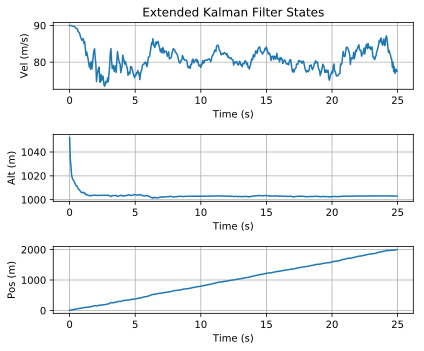

In [43]:
figure(figsize=(6,5))
subplot(311)
plot(t,XsavedEKF[:,1])
title(r'Extended Kalman Filter States')
ylabel(r'Vel (m/s)')
xlabel(r'Time (s)')
grid();
subplot(312)
plot(t,XsavedEKF[:,2])
ylabel(r'Alt (m)')
xlabel(r'Time (s)')
grid();
subplot(313)
plot(t,XsavedEKF[:,0])
ylabel(r'Pos (m)')
xlabel(r'Time (s)')
grid();
tight_layout()

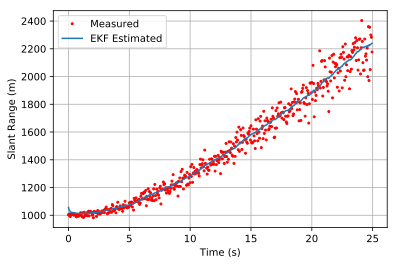

In [44]:
plot(t,XmsavedEKF,'r.',markersize=4)
plot(t,ZsavedEKF)
ylabel(r'Slant Range (m)')
xlabel(r'Time (s)')
legend((r'Measured',r'EKF Estimated'),loc='best')
grid();

## Chapter 15 Unscented KalmanFilter (UKF)
Here we focus on:

* The unscented transformation algorithm
* The estimation of the mean and convariance matrix asscociated with the joint pdf of $y = f(x)$, where in general $x$ and $y$ are vectors, e.g., the state and transformed state
* Assembling the UKF algorithm from the original KF, but with new and substitute equations due to sigma point generation and transformed sigma points
* Finally, a Radar tracking example (continuation) from Kim 15.4

<img src="figs/UKF_Filter.png" width="60%">

In [45]:
# Image('figs/UKF_Filter.png',width='70%')

### Preliminaries
First review how to slice a 2D array into a 2D column or row vector using a third argument set to `None`. Note this approach works for both right-side and left-side calculations. You know you have done something wrong when you receive a numpy `broadcasting` error.

In [46]:
A = arange(1,21).reshape(4,5)
print('# A 4 x 5 matrix:')
print(A)
print('# Slice out the second column as a 4x1 matrix')
print(A[:,1,None])
print('# Slice out the third row as a 1x5 matrix')
print(A[2,None,:])

# A 4 x 5 matrix:
[[ 1  2  3  4  5]
 [ 6  7  8  9 10]
 [11 12 13 14 15]
 [16 17 18 19 20]]
# Slice out the second column as a 4x1 matrix
[[ 2]
 [ 7]
 [12]
 [17]]
# Slice out the third row as a 1x5 matrix
[[11 12 13 14 15]]


In [47]:
def SigmaPoints(xm, P, kappa):
    """
    Calculate the Sigma Points of an unscented Kalman filter
    
    Mark Wickert December 2017
    Translated P. Kim's program from m-code
    """
    n  = xm.size
    Xi = zeros((n, 2*n+1))  # sigma points = col of Xi
    W  = zeros(2*n+1)
    Xi[:, 0, None] = xm
    W[0] = kappa/(n + kappa)

    U = cholesky((n+kappa)*P)  # U'*U = (n+kappa)*P
    
    for k in range(n):
        Xi[:, k+1, None] = xm + U[k, None, :].T   # row of U
        W[k+1] = 1/(2*(n+kappa))

    for k in range(n):
        Xi[:, n+k+1, None] = xm - U[k, None, :].T
        W[n+k+1] = 1/(2*(n+kappa))

    return Xi, W

In [48]:
def UT(Xi, W, noiseCov = 0):
    """
    Unscented transformation
    
    Mark Wickert December 2017
    Translated P. Kim's program from m-code
    """
    n, kmax = Xi.shape

    xm = zeros((n,1))
    for k in range(kmax):
        xm += W[k]*Xi[:, k, None]
        
    xcov = zeros((n, n))
    for k in range(kmax):
        xcov += W[k]*(Xi[:, k, None] - xm)*(Xi[:, k, None] - xm).T

    xcov += noiseCov
    return xm, xcov

### Verify that `SigmaPoints()` and `UT()` are working:

In [49]:
xm = array([[5],[5]])
Px = 9*eye(2)
kappa = 2

Xi, W = SigmaPoints(xm,Px,kappa) # sigma points and weights
xAvg, xCov = UT(Xi, W) # estimate mean vector and covariance matrix using sigma points

In [50]:
print(Xi)
print(W)
print(xAvg)
print(xCov)

[[ 5. 11.  5. -1.  5.]
 [ 5.  5. 11.  5. -1.]]
[0.5   0.125 0.125 0.125 0.125]
[[5.]
 [5.]]
[[9. 0.]
 [0. 9.]]


* The `xAvg` and `xCon` values match the original input values of mean and covariance

In [51]:
class RadarUKF(object):
    """
    Kim Chapter 15.4 Radar Range Tracking UKF Version
    
    Python 3.x is assumed so the operator @ can be used for matrix multiply
    
    Mark Wickert December 2017
    """

    
    def __init__ (self, dt=0.05, initial_state = [0, 90, 1100]):
        """
        Initialize the object
        """
        self.dt = dt
        self.n = 3
        self.m = 1
        # Process model covariance
        #self.Q = array([[0.01, 0, 0], [0, 0.01, 0], [0, 0, 0.01]])
        self.Q = array([[0, 0, 0], [0, 0.001, 0], [0, 0, 0.001]])
        # Measurement model covariance 
        #self.R = array([[100]])
        self.R = array([[10]])
        self.x = array([initial_state]).T
        # Error covariance initialize 
        self.P = 100*eye(3)
        self.K = zeros((self.n,1))
        # Initialize pos and vel
        self.pos = 0.0
        self.vel = 0.0
        self.alt = 0.0

        
    def next_sample(self,z,kappa = 0):
        """
        Update the Kalman filter state by inputting a new scalar measurement.
        Return the state array as a tuple
        Update all other Kalman filter quantities
        """
        Xi, W = SigmaPoints(self.x, self.P, 0)
        fXi = zeros((self.n, 2*self.n + 1))
        for k in range(2*self.n + 1):
            fXi[:, k, None] = self.fx(Xi[:,k,None])
        xp, Pp = UT(fXi, W, self.Q)
        
        hXi = zeros((self.m, 2*self.n+1))
        for k in range(2*self.n+1):
            hXi[:, k, None] = self.hx(fXi[:,k,None])
        zp, Pz = UT(hXi, W, self.R)
        
        Pxz = zeros((self.n,self.m))
        for k in range(2*self.n+1):
            Pxz += W[k]*(fXi[:,k,None] - xp) @ (hXi[:, k, None] - zp).T
        
        self.K = Pxz * inv(Pz)
        self.x = xp + self.K * (z - zp)
        self.P = Pp - self.K @ Pz @ self.K.T
        
        self.pos = self.x[0]
        self.vel = self.x[1]
        self.alt = self.x[2]
        return self.pos, self.vel, self.alt
    
    
    def fx(self,x):
        """
        The function f(x) in Kim
        """
        A = eye(3) + self.dt*array([[0, 1, 0],[0, 0, 0], [0, 0, 0]])
        xp = A @ x
        return xp
    
    
    def hx(self,x):
        """
        The range equation r(x1,x3)
        """
        yp = sqrt(x[0]**2 + x[2]**2)
        return yp

### Run a Simulation

In [52]:
dt = 0.05
Nsamples = 500
t = arange(Nsamples)*dt
Nsamples = len(t)
XsavedUKF = zeros((Nsamples,3))
XmsavedUKF = zeros(Nsamples)
ZsavedUKF = zeros(Nsamples)
KsavedUKF = zeros((Nsamples,3))

GetRadar1 = GetRadar()
RadarUKF1 = RadarUKF(dt,initial_state=[0, 90, 1100])
for k in range(Nsamples):
    xm =GetRadar1.measurement()
    XmsavedUKF[k] = xm
    XsavedUKF[k,:] = RadarUKF1.next_sample(xm)
    ZsavedUKF[k] = norm(XsavedUKF[k])
    KsavedUKF[k,:] = RadarUKF1.K.T

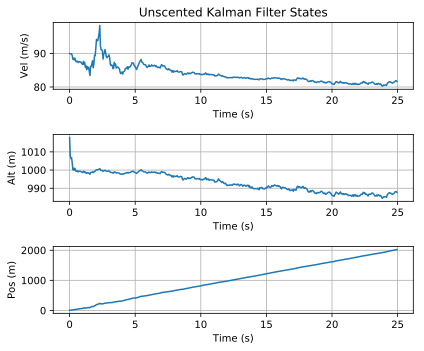

In [53]:
figure(figsize=(6,5))
subplot(311)
plot(t,XsavedUKF[:,1])
title(r'Unscented Kalman Filter States')
ylabel(r'Vel (m/s)')
xlabel(r'Time (s)')
grid();
subplot(312)
plot(t,XsavedUKF[:,2])
ylabel(r'Alt (m)')
xlabel(r'Time (s)')
grid();
subplot(313)
plot(t,XsavedUKF[:,0])
ylabel(r'Pos (m)')
xlabel(r'Time (s)')
grid();
tight_layout()

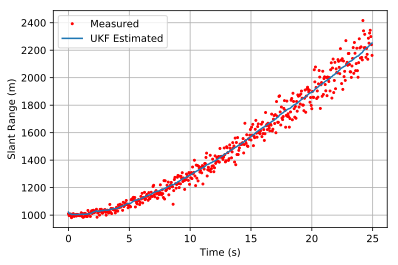

In [54]:
plot(t,XmsavedUKF,'r.',markersize=4)
plot(t,ZsavedUKF)
ylabel(r'Slant Range (m)')
xlabel(r'Time (s)')
legend((r'Measured',r'UKF Estimated'),loc='best')
grid();

* Take a look at the Kalman gains versus time for each of the states:

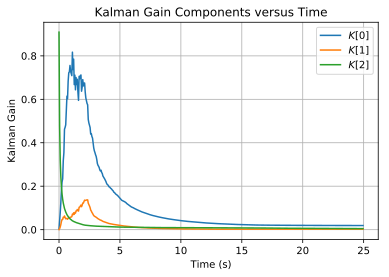

In [55]:
plot(t,KsavedUKF[:,0])
plot(t,KsavedUKF[:,1])
plot(t,KsavedUKF[:,2])
title(r'Kalman Gain Components versus Time')
ylabel(r'Kalman Gain')
xlabel(r'Time (s)')
legend((r'$K[0]$',r'$K[1]$',r'$K[2]$'),loc='best')
grid();

## References

1. [Phil Kim, *Kalman Filtering for Beginners with MATLAB Examples*, 2011.](https://www.amazon.com/Kalman-Filter-Beginners-MATLAB-Examples/dp/1463648359/ref=sr_1_9?ie=UTF8&qid=1514912616&sr=8-9&keywords=Kalman+Filtering)
2. [Robert Brown and Patrick Hwang, *Introduction to Random Signals and Applied Kalman Filtering*, 4th edition, 2012.](https://www.amazon.com/Introduction-Signals-Applied-Filtering-Exercises/dp/0470609699/ref=sr_1_3?ie=UTF8&qid=1514912616&sr=8-3&keywords=Kalman+Filtering)
3. [Elliot Kaplan, editor, *Understanding GPS Principles and Applications*, 1996 (3rd edition available).](https://www.amazon.com/Understanding-Principles-Applications-Artech-Communications/dp/0890067937/ref=sr_1_2?ie=UTF8&qid=1516027849&sr=8-2&keywords=UNderstanding+GPS)
4. [Dan Simon, *Optimal State Estimation*, 2006.](https://www.amazon.com/Optimal-State-Estimation-Nonlinear-Approaches/dp/0471708585/ref=sr_1_1?s=books&ie=UTF8&qid=1516027927&sr=1-1&keywords=Optimal+State+Estimation)